In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import optuna

from scipy.stats import shapiro
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, precision_recall_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier
from pycaret.classification import setup, compare_models, create_model
from pycaret.classification import tune_model, plot_model, evaluate_model, finalize_model
from pycaret.classification import save_model, load_model

import warnings
warnings.filterwarnings('ignore')

#### TODO's e Dúvidas

- Precisa separar treino e teste como sempre fazemos? Ou não, pois já tem 2 arquivos separados
- Testar se dados já estão normalizados, mas perguntar tb
- Ver variáveis que não são relevantes 


In [4]:
#teste = pd.read_excel('teste.xlsx')
treino = pd.read_excel('treino.xlsx')

In [96]:
treino.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,Class
0,1,-0.299468,0.533339,0.592928,0.094916,0.015414,0.019142,0.045814,0.177430,-0.040845,...,-0.006907,0.082039,0.783691,0.046401,-0.181900,0.201659,0.186339,0.052175,0.081669,0
1,2,0.529493,-0.094837,0.341711,0.568313,-0.318345,0.201856,-0.302414,0.208240,0.290601,...,-0.934574,0.248362,0.231307,-0.121390,0.045858,-0.088862,-0.320489,-0.132945,0.051778,0
2,3,0.605630,-0.024632,-0.042535,-0.023267,-0.135464,-0.141456,0.093773,-0.093751,-0.586908,...,0.681119,-0.082467,-0.037362,-0.923501,0.024895,0.135814,-0.367899,-0.084424,-0.273891,0
3,4,-0.346173,0.647783,0.473604,-0.165712,0.127780,-0.221239,0.295904,0.076857,-0.220782,...,0.560604,0.001884,0.409169,0.236170,-0.362497,-0.085438,0.210089,0.112295,-0.136954,0
4,5,0.240050,-0.688908,0.525568,0.434648,-0.371745,0.799044,-0.332958,0.227423,0.783561,...,0.561863,-0.483898,0.041915,-0.616440,0.548586,-0.956886,-0.379454,0.235959,0.035924,0


### Teste de normalidade

In [10]:
statistic, p_value = shapiro(treino['V3'])

print("Shapiro-Wilk Test:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value > alpha:
    print("Data is normally distributed (fail to reject H0)")
else:
    print("Data is not normally distributed (reject H0)")

Shapiro-Wilk Test:
Statistic: 0.9600421786308289
P-value: 0.0
Data is not normally distributed (reject H0)


In [11]:
mean = np.mean(treino['V2'])
std = np.std(treino['V2'])

print(f'Média: {mean}')
print(f'Desvio Padrão: {std}')

Média: 0.029036081885038416
Desvio Padrão: 0.5924355158583376


## Separar Treino e Teste

- Revisar para treinar apenas com o df de treino
- testar sem normalizar

In [19]:
X = treino.iloc[:, 1:-1]
y = treino['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
w_train = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train)
sample_weights = w_train[y_train]

In [77]:
w_train

array([  0.5010755 , 232.95035461])

#### Train test manual

In [5]:
treino_0 = treino[treino['Class'] == 0]
X = treino_0.iloc[:, 1:-1]
y = treino_0['Class']

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
treino_1 = treino[treino['Class'] == 1]
X_1 = treino_1.iloc[:, 1:-1]
y_1 = treino_1['Class']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

In [55]:
X_train = pd.concat([X_train_0, X_train_1], axis=0)
y_train = pd.concat([y_train_0, y_train_1], axis=0)
X_test = pd.concat([X_test_0, X_test_1], axis=0)
y_test = pd.concat([y_test_0, y_test_1], axis=0)

In [76]:
X_test.shape

(32847, 21)

## Padronizar os atributos - Necessário ou já está padronizado?

In [20]:
# Padronizar os atributos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [8]:
# Dataset completo
scaler = StandardScaler()
scaled = scaler.fit_transform(X)

In [49]:
q = pd.DataFrame(y_train)
q.reset_index(drop=True, inplace=True)
df = pd.concat([pd.DataFrame(X_train_scaled), q], axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,Class
0,0.883743,0.451785,-3.181268,-0.092848,3.078021,2.085077,0.100219,0.684181,-0.169931,-1.667751,...,-0.309599,-3.157495,1.146942,1.025462,3.249312,0.763316,-0.608861,0.103212,-0.365081,0
1,0.651727,-0.423614,0.317527,1.399800,-0.807465,-0.242039,-0.226047,-0.055376,1.270360,-0.480086,...,-0.318640,-0.813923,-2.039169,-0.772852,0.543470,-0.674180,0.481076,0.035675,-0.769843,0
2,0.767231,0.167745,0.640559,1.755205,-0.426324,0.055158,-0.661365,0.081661,0.016013,0.821763,...,0.081846,0.004214,1.072748,1.657661,-1.484868,0.464454,-1.509402,-0.434432,0.335146,0
3,1.413422,-0.037723,-1.945461,0.312777,0.343153,-0.891887,0.257855,-0.399301,0.782825,-0.382077,...,-1.501385,-0.682099,0.292220,0.219741,0.862781,-0.413893,0.057107,-0.555710,-0.776537,0
4,1.329256,-1.377481,-0.859060,-0.766406,-1.177008,-0.123470,-1.497231,0.022841,0.187670,1.050880,...,-0.787006,-0.230439,-0.187350,2.443472,-0.595040,0.343433,0.998238,0.328868,1.054984,0


### Pycaret

In [50]:
clf = setup(data = df,
            target = 'Class',
            fold_shuffle=True,
            fix_imbalance=True,
            data_split_stratify=True,
            remove_multicollinearity=True)

,Description,Value
0,Session id,2867
1,Target,Class
2,Target type,Binary
3,Original data shape,"(131384, 22)"
4,Transformed data shape,"(222958, 22)"
5,Transformed train set shape,"(183542, 22)"
6,Transformed test set shape,"(39416, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


In [51]:
model = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8141,0.8539,0.7895,0.0087,0.0172,0.0132,0.0703
1,0.7900,0.7722,0.6500,0.0067,0.0133,0.0090,0.0503
2,0.7977,0.7389,0.5000,0.0054,0.0106,0.0064,0.0346
3,0.7998,0.8190,0.8000,0.0086,0.0171,0.0128,0.0697
4,0.8081,0.8665,0.7500,0.0085,0.0167,0.0125,0.0659
5,0.8007,0.7648,0.6000,0.0065,0.0129,0.0087,0.0467
6,0.8049,0.8076,0.7000,0.0078,0.0154,0.0111,0.0593
7,0.7981,0.8228,0.7000,0.0075,0.0149,0.0106,0.0577
8,0.8084,0.7136,0.4211,0.0045,0.0090,0.0049,0.0266


In [52]:
X_test_scaled[:, 1]

array([ 0.866109  ,  0.50116737, -0.23570158, ..., -0.16632563,
        0.2821804 , -0.11846476])

In [64]:
y_pred_prob

array([[9.98659469e-01, 1.34053142e-03],
       [9.94589689e-01, 5.41031135e-03],
       [9.98484064e-01, 1.51593623e-03],
       ...,
       [9.99665907e-01, 3.34093333e-04],
       [9.98806893e-01, 1.19310677e-03],
       [9.98771275e-01, 1.22872528e-03]])

In [93]:
def objective(trial):
    params = {
        'C': trial.suggest_loguniform('C', 0.001, 10),
        #'penalty': trial.suggest_categorical('penalty', 'l2'),
        'class_weight': 'balanced',
        'solver': trial.suggest_categorical('solver', ['liblinear', 'sag', 'saga']),
        'tol': trial.suggest_loguniform("tol", 1e-5, 1e-1)
    }
    model = LogisticRegression(**params)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)

    return pr_auc

In [95]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Best Params: ', study.best_params)
print('Best Score: ', study.best_value)

[I 2023-06-19 18:33:27,524] A new study created in memory with name: no-name-d4f9769a-313d-4e92-9b6d-5be2684618f7
[I 2023-06-19 18:33:42,997] Trial 0 finished with value: 0.3765787899420069 and parameters: {'C': 0.10575910872386939, 'solver': 'saga', 'tol': 6.789529206549919e-05}. Best is trial 0 with value: 0.3765787899420069.
[I 2023-06-19 18:33:57,238] Trial 1 finished with value: 0.37617755408019843 and parameters: {'C': 0.02594116223795877, 'solver': 'sag', 'tol': 0.0004274370613705679}. Best is trial 0 with value: 0.3765787899420069.
[I 2023-06-19 18:34:12,310] Trial 2 finished with value: 0.3338171428269378 and parameters: {'C': 0.015013433585073517, 'solver': 'sag', 'tol': 7.29940365734163e-05}. Best is trial 0 with value: 0.3765787899420069.
[I 2023-06-19 18:34:26,004] Trial 3 finished with value: 0.3058536104661622 and parameters: {'C': 0.0020457218982293506, 'solver': 'sag', 'tol': 2.7688371655568944e-05}. Best is trial 0 with value: 0.3765787899420069.
[I 2023-06-19 18:34:4

Best Params:  {'C': 0.10575910872386939, 'solver': 'saga', 'tol': 6.789529206549919e-05}
Best Score:  0.3765787899420069


### Regressão Logística

In [83]:
# Treinar e avaliar um modelo de regressão logística
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train, sample_weight=sample_weights)
y_pred_val_logreg = logreg.predict(X_test_scaled)
accuracy_logreg = accuracy_score(y_test, y_pred_val_logreg)


print("Regressão Logística - Resultados de Validação:")
#print(classification_report(y_val, y_pred_val_logreg))
print("AUC Score:", roc_auc_score(y_test, y_pred_val_logreg))
print("Accuracy:", accuracy_logreg)

Regressão Logística - Resultados de Validação:
AUC Score: 0.7186643782637244
Accuracy: 0.8171826955277499


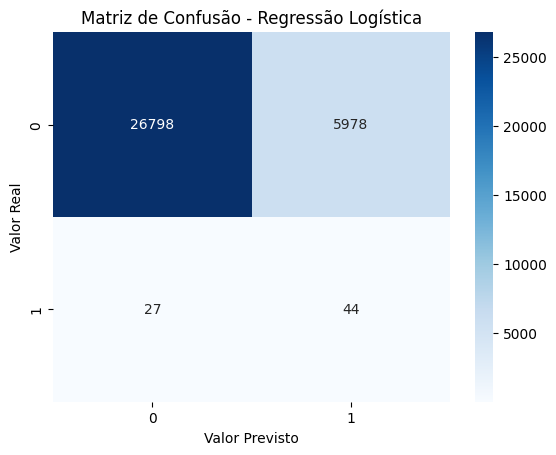

In [86]:
# Plotar a matriz de confusão - Regressão Logística
cm_logreg = confusion_matrix(y_test, y_pred_val_logreg)
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - Regressão Logística")
plt.xlabel("Valor Previsto")
plt.ylabel("Valor Real")
plt.show()

#### Cross val reg log

In [99]:
cv_reg_log_predict = cross_val_predict(logreg, X_train_scaled, y_train, cv=10)
logreg.fit(X_train_scaled, y_train, sample_weight=sample_weights)
logreg_prediction_cv = logreg.predict(X_test_scaled)

In [100]:
roc_auc_score(y_test, logreg_prediction_cv)

0.7186643782637244

### XG Boost fodase

In [94]:
from sklearn.pipeline import Pipeline
scale_pos_weight = w_train[0] / w_train[1]
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Preprocessing step
    ('xgb', xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False, random_state=42, scale_pos_weight=scale_pos_weight))  # XGBoost model
])

# Fit the pipeline
pipeline.fit(X_train_scaled, y_train)

# Predict with the pipeline
y_pred = pipeline.predict(X_test_scaled)

In [95]:
roc_xgb = roc_auc_score(y_test, y_pred)
roc_xgb

0.5

In [87]:
scale_pos_weight = w_train[0] / w_train[1]
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False, random_state=42)
xgb_classifier.fit(X_train_scaled, y_train, sample_weight=sample_weights)
y_pred_xgb = xgb_classifier.predict(X_test_scaled)
roc_xgb = roc_auc_score(y_test, y_pred_xgb)
roc_xgb

0.5067218971628158

### Light GBM

In [107]:
lgbm_clf = lgb.LGBMClassifier(objective='binary', random_state=42, metric='auc', num_leaves=31, learning_rate=0.5,
                          feature_fraction=0.9, bagging_fraction=0.8, bagging_freq=5, class_weight={0:1, 1:10})

lgbm_clf.fit(X_train_scaled, y_train)
lgbm_pred = lgbm_clf.predict(X_test_scaled)
lbgm_pred_proba = lgbm_clf.predict_proba(X_test_scaled)
roc_lgbm = roc_auc_score(y_test, lgbm_pred)
roc_lgbm_proba = roc_auc_score(y_test, lbgm_pred_proba[:, 1])

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [109]:
roc_lgbm_proba

0.37903206399735984

### KNN

In [47]:
# Treinar e avaliar um modelo k-NN
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train, )
y_pred_val_knn = knn.predict(X_val_scaled)
accuracy_knn = accuracy_score(y_val, y_pred_val_knn)

print("k-NN - Resultados de Validação:")
#print(confusion_matrix(y_val, y_pred_val_knn))
#print(classification_report(y_val, y_pred_val_knn))
print("AUC Score:", roc_auc_score(y_val, y_pred_val_knn))
print("Accuracy:", accuracy_knn)

k-NN - Resultados de Validação:
AUC Score: 0.5
Accuracy: 0.9973818004688404


In [48]:
# Fazer previsões no conjunto de teste
y_pred_test = logreg.predict(X_test_scaled)  # Utilize o modelo de regressão logística para prever as classes no conjunto de teste
y_pred_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

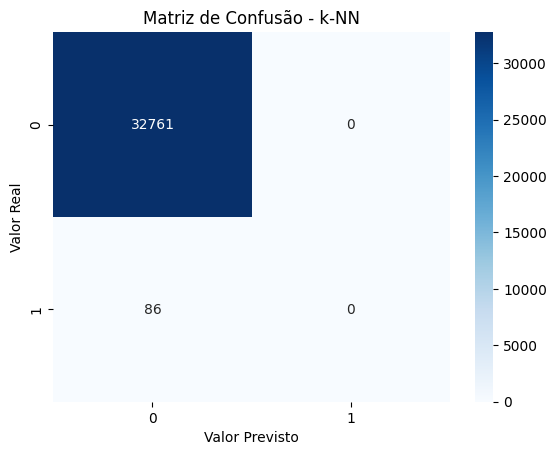

In [49]:
# Plotar a matriz de confusão - k-NN
cm_knn = confusion_matrix(y_val, y_pred_val_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - k-NN")
plt.xlabel("Valor Previsto")
plt.ylabel("Valor Real")
plt.show()

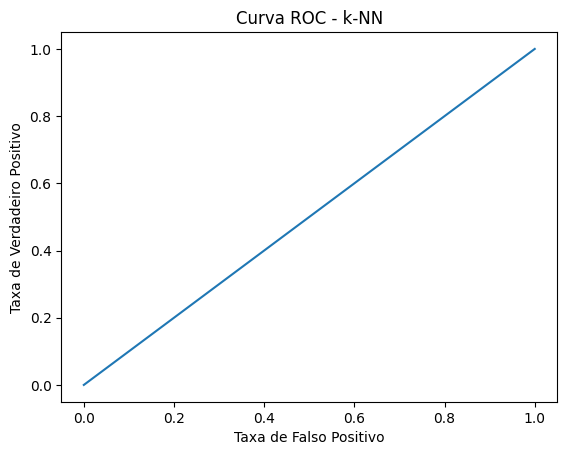

In [50]:
# Plotar a curva ROC - k-NN
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_val, y_pred_val_knn)
plt.plot(fpr_knn, tpr_knn)
plt.title("Curva ROC - k-NN")
plt.xlabel("Taxa de Falso Positivo")
plt.ylabel("Taxa de Verdadeiro Positivo")
plt.show()

# Fazer previsões no conjunto de teste
y_pred_test = logreg.predict(X_test_scaled)  # Utilize o modelo de regressão logística para prever as classes no conjunto de teste


In [17]:
output_df = pd.DataFrame({"id": teste["id"], "Class": y_pred_test})
output_df

,id,Class
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
54893,54894,0
54894,54895,0
54895,54896,0
54896,54897,0


## Árvore de Decisão

In [34]:
from sklearn.tree import DecisionTreeClassifier

# Criação do modelo
decision_tree = DecisionTreeClassifier()

# Treinamento do modelo
decision_tree.fit(X_train_scaled, y_train)

# Previsões no conjunto de validação
y_pred_val_dt = decision_tree.predict(X_val_scaled)

# Avaliação do modelo
accuracy_dt = accuracy_score(y_val, y_pred_val_dt)
print("Árvore de Decisão - Resultados de Validação:")
print(confusion_matrix(y_val, y_pred_val_dt))
print(classification_report(y_val, y_pred_val_dt))
print("AUC Score:", roc_auc_score(y_val, y_pred_val_dt))
print("Accuracy:", accuracy_dt)


Árvore de Decisão - Resultados de Validação:
[[32696    65]
 [   85     1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32761
           1       0.02      0.01      0.01        86

    accuracy                           1.00     32847
   macro avg       0.51      0.50      0.51     32847
weighted avg       0.99      1.00      1.00     32847

AUC Score: 0.5048219202781526
Accuracy: 0.995433372910768


## Random Forest

In [78]:
from sklearn.ensemble import RandomForestClassifier

# Criação do modelo
random_forest = RandomForestClassifier()

# Treinamento do modelo
random_forest.fit(X_train_scaled, y_train)

# Previsões no conjunto de validação
y_pred_val_rf = random_forest.predict(X_test)

# Avaliação do modelo
accuracy_rf = accuracy_score(y_test, y_pred_val_rf)
print("Random Forest - Resultados de Validação:")
print(confusion_matrix(y_test, y_pred_val_rf))
print(classification_report(y_test, y_pred_val_rf))
print("AUC Score:", roc_auc_score(y_test, y_pred_val_rf))
print("Accuracy:", accuracy_rf)


Random Forest - Resultados de Validação:
[[32776     0]
 [   71     0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32776
           1       0.00      0.00      0.00        71

    accuracy                           1.00     32847
   macro avg       0.50      0.50      0.50     32847
weighted avg       1.00      1.00      1.00     32847

AUC Score: 0.5
Accuracy: 0.9978384631777636


In [74]:
X_test_scaled.shape

(54898, 21)

In [75]:
y_test.shape

(32847,)

In [79]:
cv_scores = cross_val_score(random_forest, X_test_scaled, y_test, cv=5, scoring='roc_auc')
mean_score = np.mean(cv_scores)
mean_score

0.694772194743076

In [80]:
predicted_rf = cross_val_predict(random_forest, X_test_scaled, y_test, cv=5)
predicted_rf

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [86]:
r = pd.DataFrame({'Actual': y_test, 'Predicted': predicted_rf})
r['Predicted'].value_counts()

0    32846
1        1
Name: Predicted, dtype: int64

In [82]:
print("Random Forest after CV- Resultados de Validação:")
print(confusion_matrix(y_test, predicted_rf))
print(classification_report(y_test, predicted_rf))
print("AUC Score:", roc_auc_score(y_test, predicted_rf))
print("Accuracy:", accuracy_rf)

Random Forest after CV- Resultados de Validação:
[[32775     1]
 [   71     0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32776
           1       0.00      0.00      0.00        71

    accuracy                           1.00     32847
   macro avg       0.50      0.50      0.50     32847
weighted avg       1.00      1.00      1.00     32847

AUC Score: 0.4999847449353185
Accuracy: 0.9978384631777636


## Gradient Boosting

In [53]:
from sklearn.ensemble import GradientBoostingClassifier

# Criação do modelo
gradient_boosting = GradientBoostingClassifier()

# Treinamento do modelo
gradient_boosting.fit(X_train_scaled, y_train)

# Previsões no conjunto de validação
y_pred_val_gb = gradient_boosting.predict(X_val_scaled)

# Avaliação do modelo
accuracy_gb = accuracy_score(y_val, y_pred_val_gb)
print("Gradient Boosting - Resultados de Validação:")
print(confusion_matrix(y_val, y_pred_val_gb))
print(classification_report(y_val, y_pred_val_gb))
print("AUC Score:", roc_auc_score(y_val, y_pred_val_gb))
print("Accuracy:", accuracy_gb)


Gradient Boosting - Resultados de Validação:
[[32747    14]
 [   86     0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32761
           1       0.00      0.00      0.00        86

    accuracy                           1.00     32847
   macro avg       0.50      0.50      0.50     32847
weighted avg       0.99      1.00      1.00     32847

AUC Score: 0.4997863313085681
Accuracy: 0.996955581940512


## Support Vector Machines (SVM):

In [54]:
from sklearn.svm import SVC

# Criação do modelo
svm = SVC()

# Treinamento do modelo
svm.fit(X_train_scaled, y_train)

# Previsões no conjunto de validação
y_pred_val_svm = svm.predict(X_val_scaled)

# Avaliação do modelo
accuracy_svm = accuracy_score(y_val, y_pred_val_svm)
print("SVM - Resultados de Validação:")
print(confusion_matrix(y_val, y_pred_val_svm))
print(classification_report(y_val, y_pred_val_svm))
print("AUC Score:", roc_auc_score(y_val, y_pred_val_svm))
print("Accuracy:", accuracy_svm)


SVM - Resultados de Validação:
[[32761     0]
 [   86     0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32761
           1       0.00      0.00      0.00        86

    accuracy                           1.00     32847
   macro avg       0.50      0.50      0.50     32847
weighted avg       0.99      1.00      1.00     32847

AUC Score: 0.5
Accuracy: 0.9973818004688404


## Redes Neurais

In [55]:
from sklearn.neural_network import MLPClassifier

# Criação do modelo
neural_network = MLPClassifier()

# Treinamento do modelo
neural_network.fit(X_train_scaled, y_train)

# Previsões no conjunto de validação
y_pred_val_nn = neural_network.predict(X_val_scaled)

# Avaliação do modelo
accuracy_nn = accuracy_score(y_val, y_pred_val_nn)
print("Redes Neurais - Resultados de Validação:")
print(confusion_matrix(y_val, y_pred_val_nn))
print(classification_report(y_val, y_pred_val_nn))
print("AUC Score:", roc_auc_score(y_val, y_pred_val_nn))
print("Accuracy:", accuracy_nn)


Redes Neurais - Resultados de Validação:
[[32748    13]
 [   84     2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32761
           1       0.13      0.02      0.04        86

    accuracy                           1.00     32847
   macro avg       0.57      0.51      0.52     32847
weighted avg       1.00      1.00      1.00     32847

AUC Score: 0.5114295003347002
Accuracy: 0.9970469144822968


# Hiperparâmetros e validação cruzada


In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Separar atributos e variável de destino
X = treino.iloc[:, 1:-1]  # Atributos (colunas V1 a V21)
y = treino["Class"]  # Variável de destino (coluna Class)

# Definir os hiperparâmetros que serão testados
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3]
}

# Criar o classificador de Árvore de Decisão
clf = DecisionTreeClassifier()

# Criar o objeto de busca por hiperparâmetros
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# Realizar a busca por hiperparâmetros otimizados usando validação cruzada
grid_search.fit(X, y)

# Obter os melhores hiperparâmetros encontrados
best_params = grid_search.best_params_

# Treinar o modelo com os melhores hiperparâmetros encontrados
best_clf = DecisionTreeClassifier(**best_params)
best_clf.fit(X, y)

# Fazer previsões no conjunto de teste
X_test = teste.iloc[:, 1:]
y_pred = best_clf.predict(X_test)

# Calcular a acurácia das previsões
accuracy = accuracy_score(y, y_pred)

# Imprimir os melhores hiperparâmetros e a acurácia
print("Melhores hiperparâmetros:", best_params)
#Melhores hiperparâmetros: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 5}
print("Acurácia:", accuracy)


# Separar atributos e variável de destino para o conjunto de teste
X_test = teste.iloc[:, 1:]  # Atributos (colunas V1 a V21)
y_test = teste["Class"]  # Variável de destino (coluna Class)

# Fazer previsões no conjunto de teste
y_pred = best_clf.predict(X_test)

# Calcular a acurácia das previsões
accuracy = accuracy_score(y_test, y_pred)

# Imprimir os melhores hiperparâmetros e a acurácia
print("Melhores hiperparâmetros:", best_params)
print("Acurácia:", accuracy)

ValueError: Found input variables with inconsistent numbers of samples: [32847, 54898]

In [58]:
# Separar atributos e variável de destino para o conjunto de teste
X_test = teste.iloc[:, 1:]  # Atributos (colunas V1 a V21)
y_test = teste["Class"]  # Variável de destino (coluna Class)

# Fazer previsões no conjunto de teste
y_pred = best_clf.predict(X_test)

# Calcular a acurácia das previsões
accuracy = accuracy_score(y_test, y_pred)

# Imprimir os melhores hiperparâmetros e a acurácia
print("Melhores hiperparâmetros:", best_params)
print("Acurácia:", accuracy)

KeyError: 'Class'

In [57]:
print("Melhores hiperparâmetros:", best_params)

Melhores hiperparâmetros: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 5}


A acurácia é uma métrica comumente usada para avaliar a qualidade de um modelo de classificação. Ela mede a proporção de previsões corretas em relação ao total de previsões. No entanto, a acurácia nem sempre é a métrica mais confiável, especialmente quando os dados estão desbalanceados, como é o caso do seu conjunto de dados, em que a classe "fraude" é uma parcela pequena da amostra.

Em casos de desbalanceamento de classes, a acurácia pode ser enganosa, pois um modelo pode obter uma alta acurácia simplesmente prevendo a classe majoritária em todos os casos, ignorando completamente a classe minoritária. Isso pode ser problemático quando nosso interesse principal é detectar corretamente as transações fraudulentas.

Para mitigar as falhas da acurácia em cenários de desbalanceamento de classes, é recomendável considerar outras métricas, como:

    Matriz de Confusão: Uma matriz que mostra a contagem de verdadeiros positivos (TP), falsos positivos (FP), verdadeiros negativos (TN) e falsos negativos (FN). Essa matriz fornece uma visão mais detalhada do desempenho do modelo em termos de classificações corretas e incorretas.

    Precisão (Precision): Mede a proporção de verdadeiros positivos em relação ao total de previsões positivas. É uma métrica útil para avaliar o modelo em termos de quantas das previsões positivas são realmente corretas.

    Recall (Sensibilidade ou Revocação): Mede a proporção de verdadeiros positivos em relação ao total de casos positivos reais. É uma métrica útil para avaliar o modelo em termos de sua capacidade de detectar corretamente os casos positivos.

    F1-Score: É uma média harmônica entre a precisão e o recall. Fornece uma métrica equilibrada que leva em consideração tanto os verdadeiros positivos quanto os falsos negativos.

    Área sob a Curva ROC (AUC-ROC): Mede a capacidade discriminativa do modelo em distinguir entre as classes. A curva ROC representa a taxa de verdadeiros positivos em relação à taxa de falsos positivos em vários pontos de corte de probabilidade. Quanto maior a área sob a curva, melhor o desempenho do modelo.

É importante considerar essas métricas em conjunto para obter uma avaliação mais completa do desempenho do modelo. No código fornecido anteriormente, já foram incluídas as métricas de precisão, recall, F1-score e AUC-ROC para ambos os modelos de regressão logística e k-NN.

É possível comparar os modelos usando diferentes métricas de avaliação. Algumas métricas que podem ser usadas para comparar os modelos são:

    Acurácia: É a proporção de predições corretas em relação ao total de predições. Quanto maior a acurácia, melhor o modelo.

    Área sob a curva (AUC): Mede a capacidade do modelo em distinguir corretamente as classes. Quanto maior o valor da AUC, melhor o modelo.

    Precisão: Mede a proporção de verdadeiros positivos em relação ao total de predições positivas. Uma alta precisão indica que o modelo tem baixa taxa de falsos positivos.

    Revocação (Recall): Mede a proporção de verdadeiros positivos em relação ao total de amostras positivas. Uma alta revocação indica que o modelo tem baixa taxa de falsos negativos.

    F1-Score: É uma média harmônica entre precisão e revocação. Oferece uma medida balanceada entre as duas métricas.